## SVM 

+ 重要参数:
  1. kernal 
  2. C: 其中 C是惩罚系数，即对误差的宽容度。c越高，说明越不能容忍出现误差,容易过拟合。C越小，容易欠拟合。C过大或过小，泛化能力变差。C一般可以选择为：10^t , t=[- 4，4]就是0.0001 到10000。
  3. gamma

In [2]:
import random
import joblib
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from openpyxl import load_workbook
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC 
warnings.filterwarnings("ignore")

In [3]:
from sklearn.metrics import confusion_matrix    #导入计算混淆矩阵的包
def specificity_score(y_true, y_pred):
    C = confusion_matrix(y_true, y_pred)
    TP = C[1,1]
    FP = C[0,1]
    TN = C[0,0]
    FN = C[1,0]
    specificity = TN/(TN+FP)
    return specificity

def classification_evaluation(y_true, y_pred, y_score):
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    auc = metrics.roc_auc_score(y_true, y_score)
    f1 = metrics.f1_score(y_true, y_pred)
    specificity = specificity_score(y_true, y_pred)
    evaluation = {'accuracy':accuracy, 'recall':recall, 'precision':precision, 'f1':f1, 'auc':auc, 'specificity':specificity}
    return evaluation

### Global params setting and load data

In [4]:
cwd = os.getcwd()
traindir = '../Feature_filter/Feas_data'
testdir = '../Feature_filter/Feas_data_test'
imgdir = os.path.join(cwd, 'IMG')
modeldir = os.path.join(cwd, 'Model')
tag_cols = ['pid', 'label', 'series','image', 'mask']
sequence_id = [2, 3, 4]
# Generate the random seed
random_state = random.randint(1,10000)

# Load the SSM features.
SSM_train_slist = [pd.read_excel(os.path.join(traindir, 'feas_mrmr_sel.xlsx'), sheet_name=f'sequence{num}') for num in sequence_id]
SSM_test_slist = [pd.read_excel(os.path.join(testdir, 'SSM_test.xlsx'), sheet_name=f'sequence{num}') for num in sequence_id]

In [5]:
# Train data
standardscaler = StandardScaler()
SSM_train_slist = [df.sample(frac=1.0, random_state=random_state) for df in SSM_train_slist]
SSM_train_y = [df['label'] for df in SSM_train_slist]
SSM_train_x = [df.drop(tag_cols, axis=1) for df in SSM_train_slist]
SSM_train_x = [standardscaler.fit_transform(df) for df in SSM_train_x]
# Test data
SSM_test_slist = [df.sample(frac=1.0, random_state=random_state) for df in SSM_test_slist]
SSM_test_y = [df['label'] for df in SSM_test_slist]
SSM_test_x = [df.drop(tag_cols, axis=1) for df in SSM_test_slist]
SSM_test_x = [standardscaler.fit_transform(df) for df in SSM_test_x]

SSM2_train_y, SSM3_train_y, SSM4_train_y = (y_.to_list() for y_ in SSM_train_y)             
SSM2_train_x, SSM3_train_x, SSM4_train_x = (x_ for x_ in SSM_train_x)
SSM2_test_y, SSM3_test_y, SSM4_test_y = (y_.to_list() for y_ in SSM_test_y)
SSM2_test_x, SSM3_test_x, SSM4_test_x = (x_ for x_ in SSM_test_x)
SSM2_model, SSM3_model, SSM4_model = (f'SVM_SSM{i+2}.model' for i in range(3))

### 系统调参

### SSM2

#### 超参数遍历匹配择优
+ 依据上述所得到的随机最优匹配结果，进行遍历全部组合的匹配择优。

In [10]:
# Search optimal hyperparameter
random_regression_seed=np.random.randint(low=1,high=230)
C_range = np.linspace(0.1,20,50)#[0.001, 0.01, 0.1, 1.0, 10, 100, 1000] # default=1.0
# kernal_range = ['rbf', 'linear', 'sigmoid', 'poly']
gamma_range = np.linspace(0.01, 0.1,20)#[0.001, 0.0001]

hp_range={#'kernal':kernal_range,
          'C':C_range,
          'gamma':gamma_range,
          'probability': [True]
}
# Random search
model_test_base = SVC()
model_test_grid = GridSearchCV(estimator=model_test_base,
                                                   param_grid=hp_range,
                                                   n_jobs=-1,
                                                   cv=5,
                                                   verbose=1,
                                                   scoring='roc_auc'
                                                   )
model_test_grid.fit(SSM2_train_x, SSM2_train_y)

best_SVM_SSM2 = model_test_grid.best_params_
pprint(best_SVM_SSM2)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
{'C': 2.1306122448979594, 'gamma': 0.01, 'probability': True}


In [11]:
# Build RF regression model with optimal hyperparameters
SSM2=model_test_grid.best_estimator_
# Predict test set data
score = SSM2.score(SSM2_test_x, SSM2_test_y)
print(score)
joblib.dump(SSM2, os.path.join(modeldir, SSM2_model))

0.7285714285714285


['/media/tx-deepocean/Data/2022/chongfu1/Model/Train/Model/SVM_SSM2.model']

In [12]:
model= joblib.load(os.path.join(modeldir, SSM2_model)) 
predict_label = model.predict(SSM2_test_x)#, probability=True) #预测的标签
predict_score = model.predict_proba(SSM2_test_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = SSM2_test_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.7285714285714285,
 'recall': 1.0,
 'precision': 0.7076923076923077,
 'f1': 0.8288288288288288,
 'auc': 0.701086956521739,
 'specificity': 0.20833333333333334}

### SSM3

#### 超参数遍历匹配择优
+ 依据上述所得到的随机最优匹配结果，进行遍历全部组合的匹配择优。

In [13]:
# Search optimal hyperparameter
random_regression_seed=np.random.randint(low=1,high=230)

C_range = np.linspace(0.1,20,50)#[0.001, 0.01, 0.1, 1.0, 10, 100, 1000] # default=1.0
# kernal_range = ['rbf', 'linear', 'sigmoid', 'poly']
gamma_range = np.linspace(0.01, 0.1,10)#[0.001, 0.0001]

hp_range={#'kernal':kernal_range,
          'C':C_range,
          'gamma':gamma_range,
          'probability': [True]
}
# Random search
model_test_base = SVC()
model_test_grid = GridSearchCV(estimator=model_test_base,
                                                   param_grid=hp_range,
                                                   n_jobs=-1,
                                                   cv=5,
                                                   verbose=1,
                                                   scoring='balanced_accuracy'
                                                   )
model_test_grid.fit(SSM3_train_x, SSM3_train_y)

best_SVM_SSM3 = model_test_grid.best_params_
pprint(best_SVM_SSM3)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
{'C': 0.5061224489795918, 'gamma': 0.06000000000000001, 'probability': True}


In [14]:
# Build RF regression model with optimal hyperparameters
SSM3=model_test_grid.best_estimator_
# Predict test set data
score = SSM3.score(SSM3_test_x, SSM3_test_y)
print(score)
joblib.dump(SSM3, os.path.join(modeldir, SSM3_model))

0.7


['/media/tx-deepocean/Data/2022/chongfu1/Model/Train/Model/SVM_SSM3.model']

In [15]:
model= joblib.load(os.path.join(modeldir, SSM3_model)) 
predict_label = model.predict(SSM3_test_x)#, probability=True) #预测的标签
predict_score = model.predict_proba(SSM3_test_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = SSM3_test_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.7,
 'recall': 0.9347826086956522,
 'precision': 0.7049180327868853,
 'f1': 0.8037383177570093,
 'auc': 0.7409420289855072,
 'specificity': 0.25}

### SSM4

#### 超参数遍历匹配择优
+ 依据上述所得到的随机最优匹配结果，进行遍历全部组合的匹配择优。

In [16]:
# Search optimal hyperparameter
random_regression_seed=np.random.randint(low=1,high=230)
C_range = np.linspace(0.1,20,100)#[0.001, 0.01, 0.1, 1.0, 10, 100, 1000] # default=1.0
# kernal_range = ['rbf', 'linear', 'sigmoid', 'poly']
gamma_range = np.linspace(0.001, 0.05,20)#[0.001, 0.0001]

hp_range={#'kernal':kernal_range,
          'C':C_range,
          'gamma':gamma_range,
          'probability': [True]
}
# Random search
model_test_base = SVC()
model_test_grid = GridSearchCV(estimator=model_test_base,
                                                   param_grid=hp_range,
                                                   n_jobs=-1,
                                                   cv=4,
                                                   verbose=1,
                                                   scoring='balanced_accuracy'
                                                   )
model_test_grid.fit(SSM4_train_x, SSM4_train_y)

best_SVM_SSM4 = model_test_grid.best_params_
pprint(best_SVM_SSM4)

Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
{'C': 13.768686868686867, 'gamma': 0.02936842105263158, 'probability': True}


In [17]:
# Build RF regression model with optimal hyperparameters
SSM4=model_test_grid.best_estimator_
# Predict test set data
score = SSM4.score(SSM4_test_x, SSM4_test_y)
print(score)
joblib.dump(SSM4, os.path.join(modeldir, SSM4_model))

0.6857142857142857


['/media/tx-deepocean/Data/2022/chongfu1/Model/Train/Model/SVM_SSM4.model']

In [18]:
model= joblib.load(os.path.join(modeldir, SSM4_model)) 
predict_label = model.predict(SSM4_test_x)#, probability=True) #预测的标签
predict_score = model.predict_proba(SSM4_test_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = SSM4_test_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.6857142857142857,
 'recall': 0.9782608695652174,
 'precision': 0.6818181818181818,
 'f1': 0.8035714285714285,
 'auc': 0.7327898550724637,
 'specificity': 0.125}

### DSM

In [19]:
# Load the DSM features.
Dtag_cols = ['pid', 'label']
DSM_train_slist = [pd.read_excel(os.path.join(traindir, 'DSM_feas_mrmr_sel.xlsx'), sheet_name=f'no_sequence{num}') for num in sequence_id]
DSM_test_slist = [pd.read_excel(os.path.join(testdir, 'DSM_test.xlsx'), sheet_name=f'no_sequence{num}') for num in sequence_id]
# Train data
standardscaler = StandardScaler()
DSM_train_slist = [df.sample(frac=1.0, random_state=random_state) for df in DSM_train_slist]
DSM_train_y = [df['label'] for df in DSM_train_slist]
DSM_train_x = [df.drop(Dtag_cols, axis=1) for df in DSM_train_slist]
#DSM_train_x = [standardscaler.fit_transform(df) for df in DSM_train_x]
# Test data
#DSM_test_slist = [df.sample(frac=1.0, random_state=random_state) for df in DSM_test_slist]
DSM_test_y = [df['label'] for df in DSM_test_slist]
DSM_test_x = [df.drop(Dtag_cols, axis=1) for df in DSM_test_slist]
#DSM_test_x = [standardscaler.fit_transform(df) for df in DSM_test_x]

DSM2_train_y, DSM3_train_y, DSM4_train_y = (y_.to_list() for y_ in DSM_train_y)             
DSM2_train_x, DSM3_train_x, DSM4_train_x = (np.array(x_) for x_ in DSM_train_x)
DSM2_test_y, DSM3_test_y, DSM4_test_y = (y_.to_list() for y_ in DSM_test_y)
DSM2_test_x, DSM3_test_x, DSM4_test_x = (np.array(x_) for x_ in DSM_test_x)
DSM2_model, DSM3_model, DSM4_model = (f'SVM_DSM{i+2}.model' for i in range(3))

In [20]:
# 过采样
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN 
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids 
train_df = DSM_train_slist[1]
train_df = train_df.sample(frac=1.0, random_state=123)
train_df = train_df.drop(['pid'], axis=1)
train_X, train_Y = train_df.loc[:, train_df.columns != 'label'], train_df.loc[:, train_df.columns == 'label']

smote = SMOTE(k_neighbors=3, random_state=2022)
X_smote, Y_smote = smote.fit_resample(train_X, train_Y)
df_smote = pd.concat([X_smote, Y_smote], axis=1)
DSM3_train_x = np.array(df_smote.drop(['label'], axis=1))
DSM3_train_y = np.array(df_smote['label'].to_list())

# bsmote = BorderlineSMOTE(k_neighbors=2, random_state=2022)
# X_smote, Y_smote = bsmote.fit_resample(train_X, train_Y)
# df_smote = pd.concat([X_smote, Y_smote], axis=1)
# DSM3_train_x = np.array(df_smote.drop(['label'], axis=1))
# DSM3_train_y = np.array(df_smote['label'].to_list())
# 
# adasyn = ADASYN(n_neighbors=3, random_state=42)
# X_smote, Y_smote = adasyn.fit_resample(train_X, train_Y)
# df_smote = pd.concat([X_smote, Y_smote], axis=1)
# DSM3_train_x = np.array(df_smote.drop(['label'], axis=1))
# DSM3_train_y = np.array(df_smote['label'].to_list())
# 
tl = TomekLinks()
X_smote, Y_smote = tl.fit_resample(train_X, train_Y)
df_smote = pd.concat([X_smote, Y_smote], axis=1)
# 
cc = ClusterCentroids(random_state=22)
X_smote, Y_smote = cc.fit_resample(train_X, train_Y)
df_smote = pd.concat([X_smote, Y_smote], axis=1)

DSM3_train_x = df_smote.drop(['label'], axis=1)
DSM3_train_y = df_smote['label'].to_list()
print(df_smote.groupby('label').count())

       glszm_SmallAreaEmphasis_logarithm2  glcm_InverseVariance_exponential2  \
label                                                                          
0                                      55                                 55   
1                                      55                                 55   

       glrlm_ShortRunLowGrayLevelEmphasis_square4  \
label                                               
0                                              55   
1                                              55   

       glszm_GrayLevelNonUniformity_wavelet-HHH2  \
label                                              
0                                             55   
1                                             55   

       glcm_Correlation_log-sigma-3-0-mm-3D2  glszm_ZoneEntropy_exponential4  \
label                                                                          
0                                         55                              55   
1                

In [94]:
# external test
DSM_test_external = pd.read_csv(os.path.join(testdir, 'DSM_test_external.csv'))
DSM3_extest_y = DSM_test_external['label']
DSM3_extest_x = DSM_test_external.drop(Dtag_cols, axis=1)
DSM_test_external.head()

,pid,label,glszm_SmallAreaEmphasis_logarithm2,glcm_InverseVariance_exponential2,glrlm_ShortRunLowGrayLevelEmphasis_square4,glszm_GrayLevelNonUniformity_wavelet-HHH2,glcm_Correlation_log-sigma-3-0-mm-3D2,glszm_ZoneEntropy_exponential4,firstorder_Skewness_logarithm2
0,1,1,-0.082571,-1.467897,-0.371897,-0.403232,-0.163733,-0.537051,-0.044727
1,2,0,0.343019,1.377483,-0.326643,2.612101,0.663478,0.046500,-1.606117
2,3,0,1.248603,0.698196,-0.326643,-0.536871,-2.005267,0.046500,-0.960588
3,4,1,0.044844,-0.316359,-1.180298,0.074876,0.596528,-0.746848,1.090658
4,5,1,-1.067449,2.091546,0.837405,-0.577231,0.388151,1.330975,-2.159078


In [95]:
# Search optimal hyperparameter
random_regression_seed=np.random.randint(low=1,high=230)

C_range = np.linspace(0.1,20,50)#[0.001, 0.01, 0.1, 1.0, 10, 100, 1000] # default=1.0
# kernal_range = ['rbf', 'linear', 'sigmoid', 'poly']
gamma_range = np.linspace(0.001, 1,50)#[0.001, 0.0001]

hp_range={#'kernal':kernal_range,
          'C':C_range,
          'gamma':gamma_range,
          'probability': [True]
}
# Random search
model_test_base = SVC()
model_test_grid = GridSearchCV(estimator=model_test_base,
                                                   param_grid=hp_range,
                                                   n_jobs=-1,
                                                   cv=5,
                                                   verbose=1,
                                                   scoring='balanced_accuracy'
                                                   #scoring='neg_root_mean_squared_error',
                                                   )
model_test_grid.fit(DSM3_train_x, DSM3_train_y)

best_SVM_DSM3 = model_test_grid.best_params_
pprint(best_SVM_DSM3)

Fitting 5 folds for each of 2500 candidates, totalling 12500 fits
{'C': 0.1, 'gamma': 0.12332653061224491, 'probability': True}


In [96]:
# Build RF regression model with optimal hyperparameters
DSM3=model_test_grid.best_estimator_
# Predict test set data
score = DSM3.score(DSM3_test_x, DSM3_test_y)
print(score)
joblib.dump(DSM3, os.path.join(modeldir, DSM3_model))

0.6714285714285714


['/media/tx-deepocean/Data/2022/chongfu1/Model/Train/Model/SVM_DSM3.model']

In [97]:
model= joblib.load(os.path.join(modeldir, DSM3_model)) 
predict_label = model.predict(DSM3_test_x)#, probability=True) #预测的标签
predict_score = model.predict_proba(DSM3_test_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = DSM3_test_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.6714285714285714,
 'recall': 0.717391304347826,
 'precision': 0.7674418604651163,
 'f1': 0.7415730337078652,
 'auc': 0.3528079710144928,
 'specificity': 0.5833333333333334}

In [98]:
model= joblib.load(os.path.join(modeldir, DSM3_model)) 
predict_label = model.predict(DSM3_extest_x) #预测的标签
predict_score = model.predict_proba(DSM3_extest_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = DSM3_extest_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.5777777777777777,
 'recall': 0.6153846153846154,
 'precision': 0.64,
 'f1': 0.6274509803921569,
 'auc': 0.4412955465587045,
 'specificity': 0.5263157894736842}

### ASM

In [336]:
# Load the ASM features.
Atag_cols = ['pid', 'label']
ASM_train = pd.read_csv(os.path.join(traindir, 'ASM_mrmr_feas.csv')) 
ASM_test = pd.read_csv(os.path.join(testdir, 'ASM_test.csv')) 
# Train data
standardscaler = StandardScaler()
ASM_train = ASM_train.sample(frac=1.0, random_state=random_state) 
ASM_train_y = ASM_train['label'] 
ASM_train_x = ASM_train.drop(Atag_cols, axis=1) 
ASM_train_x = standardscaler.fit_transform(ASM_train_x) 
# Test data
ASM_test = ASM_test.sample(frac=1.0, random_state=random_state)
ASM_test_y = ASM_test['label']
ASM_test_x =ASM_test.drop(Dtag_cols, axis=1)
ASM_test_x = standardscaler.fit_transform(ASM_test_x)

ASM_model = f'SVM_ASM.model'

In [358]:
# Search optimal hyperparameter
random_regression_seed=np.random.randint(low=1,high=230)

C_range = np.linspace(0.1,20,50)#[0.001, 0.01, 0.1, 1.0, 10, 100, 1000] # default=1.0
# kernal_range = ['rbf', 'linear', 'sigmoid', 'poly']
gamma_range = np.linspace(0.01, 0.1,10)#[0.001, 0.0001]

hp_range={#'kernal':kernal_range,
          'C':C_range,
          'gamma':gamma_range,
          'probability': [True]
}
# Random search
model_test_base = SVC()
model_test_grid = GridSearchCV(estimator=model_test_base,
                                                   param_grid=hp_range,
                                                   n_jobs=-1,
                                                   cv=5,
                                                   verbose=1,
                                                   scoring='accuracy'
                                                   )
model_test_grid.fit(ASM_train_x, ASM_train_y)

best_SVM_ASM = model_test_grid.best_params_
pprint(best_SVM_ASM)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
{'C': 0.5061224489795918, 'gamma': 0.020000000000000004, 'probability': True}


In [359]:
# Build RF regression model with optimal hyperparameters
ASM=model_test_grid.best_estimator_
# Predict test set data
score = ASM.score(ASM_test_x, ASM_test_y)
print(score)
joblib.dump(ASM, os.path.join(modeldir, ASM_model))

0.7285714285714285


['/media/tx-deepocean/Data/2022/chongfu1/Model/Train/Model/SVM_ASM.model']

In [360]:
model= joblib.load(os.path.join(modeldir, ASM_model)) 
predict_label = model.predict(ASM_test_x)#, probability=True) #预测的标签
predict_score = model.predict_proba(ASM_test_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = ASM_test_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.7285714285714285,
 'recall': 0.9782608695652174,
 'precision': 0.7142857142857143,
 'f1': 0.8256880733944955,
 'auc': 0.7182971014492754,
 'specificity': 0.25}

### Clinical

In [31]:
# Load the Clinical features.
Atag_cols = ['pid', 'label']
Clinical_train = pd.read_csv(os.path.join(traindir, 'clinical_lasso_sel.csv')) 
Clinical_test = pd.read_csv(os.path.join(testdir, 'clinical_test.csv')) 
# Train data
standardscaler = StandardScaler()
Clinical_train = Clinical_train.sample(frac=1.0, random_state=random_state) 
Clinical_train_y = Clinical_train['label'] 
Clinical_train_x = Clinical_train.drop(Atag_cols, axis=1) 
#Clinical_train_x = standardscaler.fit_transform(Clinical_train_x) 
# Test data
#Clinical_test = Clinical_test.sample(frac=1.0, random_state=random_state)
Clinical_test_y = Clinical_test['label']
Clinical_test_x =Clinical_test.drop(Dtag_cols, axis=1)
#Clinical_test_x = standardscaler.fit_transform(Clinical_test_x)

Clinical_model = f'SVM_Clinical.model'

In [32]:
# Search optimal hyperparameter
random_regression_seed=np.random.randint(low=1,high=230)

C_range = np.linspace(0.1,20,50)#[0.001, 0.01, 0.1, 1.0, 10, 100, 1000] # default=1.0
# kernal_range = ['rbf', 'linear', 'sigmoid', 'poly']
gamma_range = np.linspace(0.01, 0.1,10)#[0.001, 0.0001]

hp_range={#'kernal':kernal_range,
          'C':C_range,
          'gamma':gamma_range,
          'probability': [True]
}
# Random search
model_test_base = SVC()
model_test_grid = GridSearchCV(estimator=model_test_base,
                                                   param_grid=hp_range,
                                                   n_jobs=-1,
                                                   cv=3,
                                                   verbose=1,
                                                   scoring='balanced_accuracy'
                                                   )
model_test_grid.fit(Clinical_train_x, Clinical_train_y)

best_SVM_Clinical = model_test_grid.best_params_
pprint(best_SVM_Clinical)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
{'C': 20.0, 'gamma': 0.07, 'probability': True}


In [33]:
# Build RF regression model with optimal hyperparameters
Clinical=model_test_grid.best_estimator_
# Predict test set data
score = Clinical.score(Clinical_test_x, Clinical_test_y)
print(score)
joblib.dump(Clinical, os.path.join(modeldir, Clinical_model))

0.8571428571428571


['/media/tx-deepocean/Data/2022/chongfu1/Model/Train/Model/SVM_Clinical.model']

In [34]:
model= joblib.load(os.path.join(modeldir, Clinical_model)) 
predict_label = model.predict(Clinical_test_x)#, probability=True) #预测的标签
predict_score = model.predict_proba(Clinical_test_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = Clinical_test_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.8571428571428571,
 'recall': 0.8695652173913043,
 'precision': 0.9090909090909091,
 'f1': 0.888888888888889,
 'auc': 0.8885869565217391,
 'specificity': 0.8333333333333334}

### 绘制混淆矩阵

有些概念比较混淆，例如准确率、精准率等。

准确率(accurary)：（正确预测0的个数+正确预测1的个数）/ 所有样本数

精确率(precision)=查准率：预测为1中真实为1的样本数 / 预测为1的样本数

真阳性率(True Positive Rate, TPR)=灵敏度(sensitivity)=敏感度=召回率(recall)=标签1的查全率：正确预测1的个数 / 实际1的样本数

假阳性率(False Positive Rate, FPR)=1-真阴率 ：预测为0中真实为1的样本数 / 实际0的样本数

真阴性率(True Negative Rate,TNR)=特异度(specificity)=标签0的查全率：正确预测0的个数 / 实际0的样本数

## DSM confusion_matrix

In [247]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc  
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score,train_test_split
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter, ScalarFormatter
import numpy as np
import pandas as pd

# Set the global font same as the sci-paper.
plt.rc('font',family='Times New Roman')
# 修改公式中默认字体
plt.rcParams['mathtext.default'] = 'regular'
# Set the figure size
plt.rcParams['figure.figsize'] = (12, 10) 
plt.rcParams['axes.labelsize'] = 42

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['lines.color'] = 'r'

# 定义字体font1
font1 = {'family': 'Times New Roman',
'weight': 'normal',
'size': 15,
}


from math import sqrt

# Calculate the confidence interval of the 
def roc_auc_ci(y_true, y_score, positive=1):
    AUC = roc_auc_score(y_true, y_score)
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, upper)

# Define the ROC Plot on the subplot(ax).
def roc_plot_inside(y_true, y_score, label, ax, positive=1):
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    fpr,tpr,threshold = roc_curve(y_true, y_score, pos_label=positive) ###计算真正率和假                            
    roc_auc = auc(fpr,tpr) ###计算auc的值
    roc_auc_low, roc_auc_up = roc_auc_ci(y_true, y_score, positive)
    if roc_auc_up > 1.0:
        roc_auc_up = 1.0
    ax.plot(fpr, tpr, 
             lw=2, label='{3} (AUC={0:0.3f},95%CI:({1:0.3f}-{2:0.3f}))'.format(roc_auc,roc_auc_low,roc_auc_up,label)) ###假正率为横坐标，真正率为纵坐标做曲线
    
    
# 计算混淆矩阵
from sklearn.metrics import confusion_matrix    #导入计算混淆矩阵的包
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from pylab import mpl
mpl.rcParams['font.family'] = 'Times New Roman'
import seaborn as sns #导入包

# To draw the  confusion-matrix based on the truth and predicted label.
# out_fig: the output fig name(include path);
def confusion_matrix_plot(true_label, predict, out_fig, fig_title):
    C = confusion_matrix(true_label, predict)
    fig, ax = plt.subplots(figsize=(12,10))
    df=pd.DataFrame(C)
    sns.heatmap(df, fmt='g', annot=True, cmap='Blues', ax=ax, annot_kws={"size":35})
    ax.set_xlabel('Predict',fontsize=42, color='k') #x轴label的文本和字体大小
    ax.set_ylabel('True',fontsize=42, color='k') #y轴label的文本和字体大小
    ax.tick_params(labelsize=35)
    #设置colorbar的刻度字体大小
    cax = plt.gcf().axes[-1] 
    cax.tick_params(labelsize=35)
    #设置colorbar的label文本和字体大小
    cbar = ax.collections[0].colorbar
    # cbar.set_label(r'$NMI$',fontdict=font1)
    ax.set_title(fig_title, fontsize=42)
    plt.savefig(out_fig,dpi=300, bbox_inches='tight')
    
def calcu_evaluation(true_label, predict):
    C = confusion_matrix(true_label, predict)
    TP = C[1,1]
    FP = C[0,1]
    TN = C[0,0]
    FN = C[1,0]
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    return sensitivity, specificity, accuracy

sensitivity, sepcificity and accuracy are (0.9565217391304348, 0.25, 0.7142857142857143), respectively


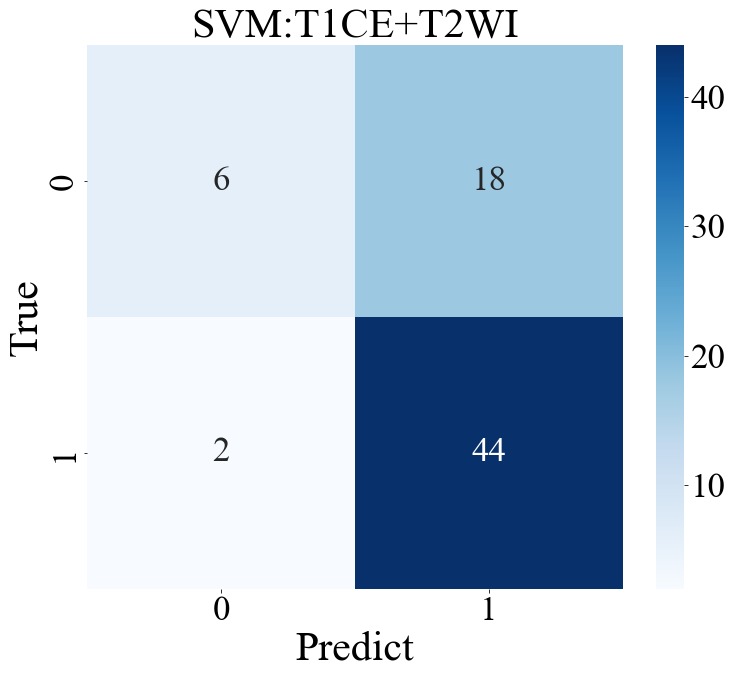

In [248]:
model= joblib.load(os.path.join(modeldir, DSM3_model)) 
y_pred = model.predict(DSM3_test_x)#, probability=True) #预测的标签
y_score = model.predict_proba(DSM3_test_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
y_true = DSM3_test_y  #真实标签
confusion_matrix_plot(y_true, y_pred,'./IMG/SVM_DSM3_confusion.png', 'SVM:T1CE+T2WI')
print(f'sensitivity, sepcificity and accuracy are {calcu_evaluation(y_true, y_pred)}, respectively')

### 绘制ROC图表

In [82]:
model_forest = joblib.load(os.path.join(modeldir, 'model_forest0.model')) #这是自己训练模型，记得替换自己的。
predict_label = model_forest.predict(rforest_test_x) #预测的标签
y_predict = model_forest.predict_proba(rforest_test_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = rforest_test_y.to_list()  #真实标签

<Figure size 864x720 with 0 Axes>

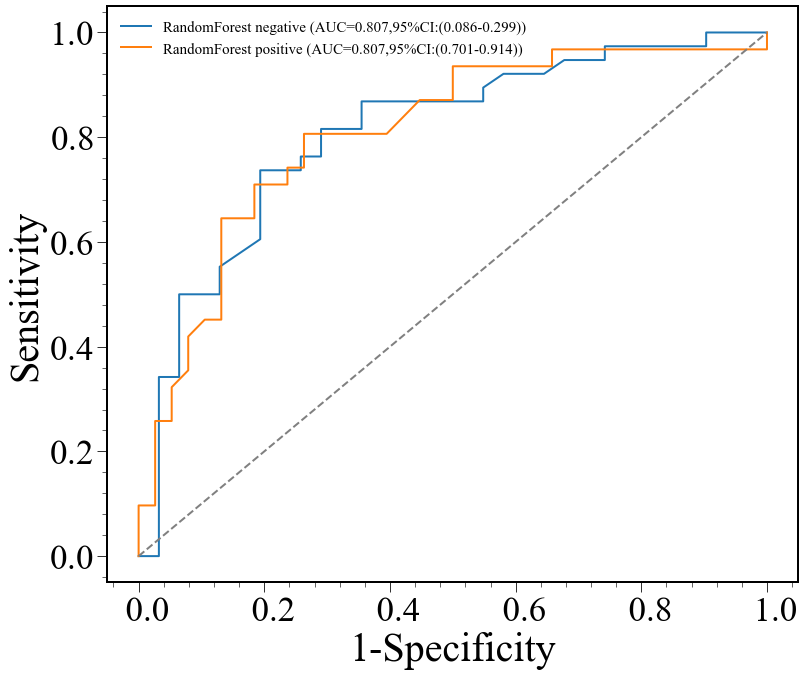

In [92]:
plt.clf()
fig = plt.figure()

# Set offset for margin
left, bottom, width, height = 0.15, 0.15, 0.8, 0.8
ax = fig.add_axes([left,bottom,width,height])
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

roc_plot_inside(label, y_predict[:,0], 'RandomForest negative', ax, positive=0)
roc_plot_inside(label, y_predict[:,1], 'RandomForest positive', ax, positive=1)
ax.plot([0, 1], [0, 1], lw=2, color='grey', linestyle='--')
# Set width of retangle
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=40)

# Set x, y-axis label and fontsize.
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1-Specificity')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 0.2
yinter = 0.2
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.1f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#显示次刻度标签的位置,没有标签文本
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.offsetText.set_fontsize(30)

legend = ax.legend(loc = 0, prop=font1)#, prop = font1, framealpha=1.0)
frame = legend.get_frame()
frame.set_alpha(0)
frame.set_facecolor('none') # 设置图例legend背景透明
fig.savefig("./Data/IMG/ROC.png", dpi=300)

### 绘制PR curve

/home/tx-deepocean/anaconda3/envs/python3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


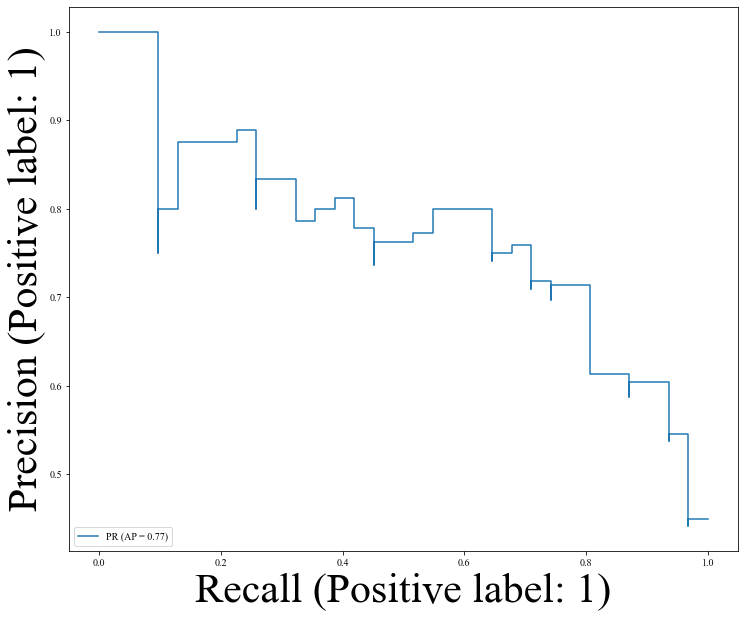

In [90]:
#绘制PR曲线，一行代码
from sklearn.metrics import plot_precision_recall_curve
plot_precision_recall_curve(model_forest, rforest_test_x, rforest_test_y,name='PR',pos_label=1)

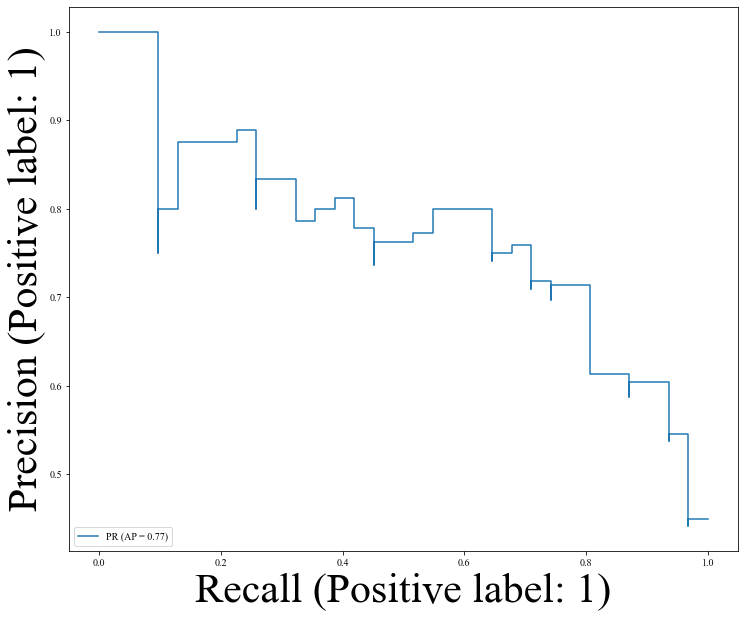

In [91]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(model_forest, rforest_test_x, rforest_test_y,name='PR',pos_label=1)

In [95]:
import sklearn
dir(sklearn.metrics)

['ConfusionMatrixDisplay',
 'DetCurveDisplay',
 'DistanceMetric',
 'PrecisionRecallDisplay',
 'RocCurveDisplay',
 'SCORERS',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_base',
 '_classification',
 '_dist_metrics',
 '_pairwise_fast',
 '_plot',
 '_ranking',
 '_regression',
 '_scorer',
 'accuracy_score',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'auc',
 'average_precision_score',
 'balanced_accuracy_score',
 'brier_score_loss',
 'calinski_harabasz_score',
 'check_scoring',
 'classification_report',
 'cluster',
 'cohen_kappa_score',
 'completeness_score',
 'confusion_matrix',
 'consensus_score',
 'coverage_error',
 'd2_tweedie_score',
 'davies_bouldin_score',
 'dcg_score',
 'det_curve',
 'euclidean_distances',
 'explained_variance_score',
 'f1_score',
 'fbeta_score',
 'fowlkes_mallows_score',
 'get_scorer',
 'hamming_loss',
 'hinge_loss',
 'homogeneity_completeness_v_measure',
 '